<a href="https://colab.research.google.com/github/PhamTrinhDuc/Text-Classification-using-Transformer-and-Pretrained-BERT/blob/main/Vision_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#AI VIET NAM
#Transformer Applications
# Vision Transformer

#**1. Image Classification using Vision Transformer**

### **1.1. Load Dataset**

In [ ]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torch import nn
import math
import os

In [ ]:
!gdown 11Buzytn4vIh4x_Oqz8MY29JMMdIqSzj-

Failed to retrieve file url:

	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=11Buzytn4vIh4x_Oqz8MY29JMMdIqSzj-

but Gdown can't. Please check connections and permissions.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/dataset/flower_photos.zip

In [ ]:
data_patch = "./flower_photos"

In [ ]:
dataset = ImageFolder(root=data_patch)

In [ ]:
num_samples = len(dataset)
classes = dataset.classes
num_classes = len(dataset.classes)
print(num_samples)

3670


In [ ]:
TRAIN_RATIO, VALID_RATIO = 0.8, 0.1

n_train_examples = int(num_samples * TRAIN_RATIO)
n_valid_examples = int(num_samples * VALID_RATIO)
n_test_examples = num_samples - n_train_examples - n_valid_examples

In [ ]:
train_dataset, valid_dataset, test_dataset = random_split(
    dataset,
    [n_train_examples, n_valid_examples, n_test_examples]
)

In [ ]:
train_dataset[0]

(<PIL.Image.Image image mode=RGB size=320x238>, 3)

### **1.2. Preprocessing**

In [ ]:
# resize + convert to tensor
IMG_SIZE = 224

train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [ ]:
train_dataset.dataset.transform = train_transforms
valid_dataset.dataset.transform = test_transforms
test_dataset.dataset.transform = test_transforms

### **1.3. Dataloader**

In [ ]:
BATCH_SIZE = 4

train_loader = DataLoader(
    train_dataset,
    shuffle=True,
    batch_size=BATCH_SIZE
)

val_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE
)

### **1.4. Modeling**

In [ ]:
class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1):
        super().__init__()
        self.attn = nn.MultiheadAttention(
            embed_dim=embed_dim,
            num_heads=num_heads,
            batch_first=True
        )
        self.ffn = nn.Sequential(
            nn.Linear(in_features=embed_dim, out_features=ff_dim, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=ff_dim, out_features=embed_dim, bias=True)
        )
        self.layernorm_1 = nn.LayerNorm(normalized_shape=embed_dim, eps=1e-6)
        self.layernorm_2 = nn.LayerNorm(normalized_shape=embed_dim, eps=1e-6)
        self.dropout_1 = nn.Dropout(p=dropout)
        self.dropout_2 = nn.Dropout(p=dropout)

    def forward(self, query, key, value):
        attn_output, _ = self.attn(query, key, value)
        attn_output = self.dropout_1(attn_output)
        out_1 = self.layernorm_1(query + attn_output)
        ffn_output = self.ffn(out_1)
        ffn_output = self.dropout_2(ffn_output)
        out_2 = self.layernorm_2(out_1 + ffn_output)
        return out_2

class PatchPositionEmbedding(nn.Module):
    def __init__(self, image_size=224, embed_dim=512, patch_size=16, device='cpu'):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=embed_dim, kernel_size=patch_size, stride=patch_size, bias=False)
        scale = embed_dim ** -0.5
        self.positional_embedding = nn.Parameter(scale * torch.randn((image_size // patch_size) ** 2, embed_dim))
        self.device = device

    def forward(self, x):
        x = self.conv1(x) # shape = [*, width, grid, grid]
        x = x.reshape(x.shape[0], x.shape[1], -1)  # shape = [*, width, grid ** 2]
        x = x.permute(0, 2, 1)  # shape = [*, grid ** 2, width]

        x = x + self.positional_embedding.to(self.device)
        return x

In [ ]:
class VisionTransformerCls(nn.Module):
    def __init__(self,
                 image_size, embed_dim, num_heads, ff_dim,
                 dropout=0.1, device='cpu', num_classes = 10, patch_size=16
        ):
        super().__init__()
        self.embd_layer = PatchPositionEmbedding(
            image_size=image_size, embed_dim=embed_dim, patch_size=patch_size, device=device
        )
        self.transformer_layer = TransformerEncoder(
            embed_dim, num_heads, ff_dim, dropout
        )
        self.fc1 = nn.Linear(in_features=embed_dim, out_features=20)
        self.fc2 = nn.Linear(in_features=20, out_features=num_classes)
        self.dropout = nn.Dropout(p=dropout)
        self.relu = nn.ReLU()
    def forward(self, x):
        output = self.embd_layer(x)
        output = self.transformer_layer(output, output, output)
        output = output[:, 0, :]
        output = self.dropout(output)
        output = self.fc1(output)
        output = self.dropout(output)
        output = self.fc2(output)
        return output

### **1.5. Training**

In [ ]:
image_size=224
embed_dim = 512
num_heads = 4
ff_dim = 128
dropout=0.1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VisionTransformerCls(
    image_size=224, embed_dim=512, num_heads=num_heads, ff_dim=ff_dim, dropout=dropout, num_classes=num_classes, device=device
)
model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00005)

num_epochs = 50
save_model = './vit_flowers'
os.makedirs(save_model, exist_ok = True)
model_name = 'vit_flowers'

model, metrics = train(
    model, model_name, save_model, optimizer, criterion, train_loader, val_loader, num_epochs, device
)

| epoch   1 |    50/  734 batches | accuracy    0.260
| epoch   1 |   100/  734 batches | accuracy    0.395
| epoch   1 |   150/  734 batches | accuracy    0.400
| epoch   1 |   200/  734 batches | accuracy    0.360
| epoch   1 |   250/  734 batches | accuracy    0.415
| epoch   1 |   300/  734 batches | accuracy    0.395
| epoch   1 |   350/  734 batches | accuracy    0.360
| epoch   1 |   400/  734 batches | accuracy    0.435
| epoch   1 |   450/  734 batches | accuracy    0.375
| epoch   1 |   500/  734 batches | accuracy    0.400
| epoch   1 |   550/  734 batches | accuracy    0.385
| epoch   1 |   600/  734 batches | accuracy    0.445
| epoch   1 |   650/  734 batches | accuracy    0.430
| epoch   1 |   700/  734 batches | accuracy    0.415
-----------------------------------------------------------
| End of epoch   1 | Time: 24.93s | Train Accuracy    0.356 | Train Loss    1.404 | Valid Accuracy    0.490 | Valid Loss    1.257 
-----------------------------------------------------

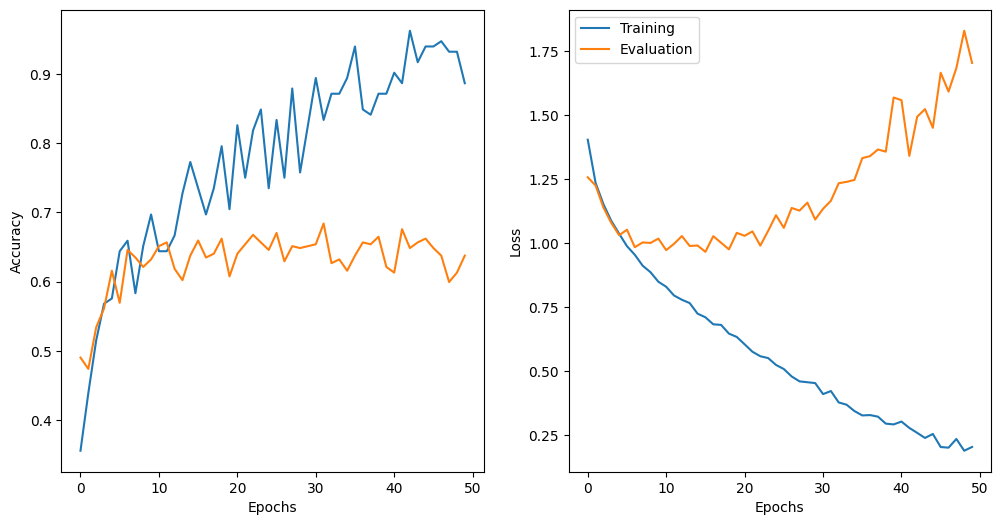

In [ ]:
plot_result(
    num_epochs,
    metrics["train_accuracy"],
    metrics["valid_accuracy"],
    metrics["train_loss"],
    metrics["valid_loss"]
)

In [ ]:
test_acc, test_loss = evaluate_epoch(model, criterion, test_loader, device)
test_acc, test_loss

(0.6348773841961853, 1.821585213145464)

# **2. Image Classification Vision Transformer Transfer Learning**

In [ ]:
!pip install accelerate==0.20.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 1.8 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.20.1
    Uninstalling accelerate-0.20.1:
      Successfully uninstalled accelerate-0.20.1


### **2.1. Define the model**

In [ ]:
from transformers import ViTForImageClassification

id2label = {id:label for id, label in enumerate(classes)}
label2id = {label:id for id,label in id2label.items()}

model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels=num_classes,
    id2label=id2label,
    label2id=label2id
)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

### **2.2. Metric**

In [ ]:
from datasets import load_metric
import numpy as np

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

### **3.3. Trainer**

In [ ]:
from transformers import ViTImageProcessor

feature_extractor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [ ]:
from transformers import TrainingArguments, Trainer

metric_name = "accuracy"

args = TrainingArguments(
    f"vit_flowers",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_dir='logs',
    remove_unused_columns=False,
)

In [ ]:
import torch

def collate_fn(examples):
    # example => Tuple(image, label)
    pixel_values = torch.stack([example[0] for example in examples])
    labels = torch.tensor([example[1] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}


trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=feature_extractor,
)

### **3.4. Training**

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.451454,0.956403
2,No log,0.245951,0.970027
3,No log,0.203870,0.964578
4,No log,0.173871,0.964578
5,No log,0.162189,0.967302
6,0.262600,0.166835,0.961853
7,0.262600,0.154129,0.967302
8,0.262600,0.152185,0.967302
9,0.262600,0.155330,0.964578
10,0.262600,0.152514,0.961853


TrainOutput(global_step=920, training_loss=0.16922692215960958, metrics={'train_runtime': 1223.6272, 'train_samples_per_second': 23.994, 'train_steps_per_second': 0.752, 'total_flos': 2.2752259898322125e+18, 'train_loss': 0.16922692215960958, 'epoch': 10.0})

In [ ]:
outputs = trainer.predict(test_dataset)

In [ ]:
outputs.metrics

{'test_loss': 0.2617303729057312,
 'test_accuracy': 0.9509536784741145,
 'test_runtime': 7.4318,
 'test_samples_per_second': 49.382,
 'test_steps_per_second': 1.615}